##      **Wild Animal Image Classification**

# Downloading the Dataset
First, we need to install the Kaggle API and authenticate it to download the "Wild animal Image" dataset.

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d whenamancodes/wild-animals-images
!unzip wild-animals-images.zip -d wild-animals-dataset

Streaming output truncated to the last 5000 lines.
  inflating: wild-animals-dataset/cheetah-resize-224/resize-224/00000236_224resized.png  
  inflating: wild-animals-dataset/cheetah-resize-224/resize-224/00000239_224resized.png  
  inflating: wild-animals-dataset/cheetah-resize-224/resize-224/00000240_224resized.png  
  inflating: wild-animals-dataset/cheetah-resize-224/resize-224/00000242_224resized.png  
  inflating: wild-animals-dataset/cheetah-resize-224/resize-224/00000244_224resized.png  
  inflating: wild-animals-dataset/cheetah-resize-224/resize-224/00000245_224resized.png  
  inflating: wild-animals-dataset/cheetah-resize-224/resize-224/00000246_224resized.png  
  inflating: wild-animals-dataset/cheetah-resize-224/resize-224/00000247_224resized.png  
  inflating: wild-animals-dataset/cheetah-resize-224/resize-224/00000248_224resized.png  
  inflating: wild-animals-dataset/cheetah-resize-224/resize-224/00000250_224resized.png  
  inflating: wild-animals-dataset/cheetah-resize-

# Creating CSV files for train and test dataset :-

we are pre-processing the data and creating train_data.csv  and test_data.csv file with columns image_path and label for further processing:-


In [6]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Directories for train and validation datasets
train_dir = '/content/wild-animals-dataset'

# Initialize lists to hold image paths and labels
image_paths = []
labels = []

# Function to process each directory
def process_directory(directory, label_list, path_list):
    for label_dir in os.listdir(directory):
        full_label_dir = os.path.join(directory, label_dir)
        if os.path.isdir(full_label_dir):
            # Extract label from the directory name before the first hyphen
            label = label_dir.split('-')[0]
            for root, _, files in os.walk(full_label_dir):
                for file in files:
                    if file.endswith('.jpg') or file.endswith('.png'):
                        image_path = os.path.join(root, file)
                        path_list.append(image_path)
                        label_list.append(label)
        else:
            print(f"{full_label_dir} is not a directory")

# Process the directories
process_directory(train_dir, labels, image_paths)

# Debugging: Check the number of images and labels collected
print(f"Number of images collected: {len(image_paths)}")
print(f"Number of labels collected: {len(labels)}")

# Split the data into train and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.1, random_state=42)

# Create DataFrame for train data
train_data = {'Image_Path': train_paths, 'Labels': train_labels}
train_df = pd.DataFrame(train_data)

# Debugging: Check the train DataFrame content
print(f"Train DataFrame head:\n{train_df.head()}")

# Create DataFrame for test data with True_Labels and Predicted_Labels columns
test_data = {'Image_Path': test_paths, 'True_Labels': test_labels, 'Predicted_Labels': 'Unknown'}
test_df = pd.DataFrame(test_data)

# Save train and test data to CSV
train_csv_path = '/content/wild-animals-dataset/train_data.csv'
train_df.to_csv(train_csv_path, index=False)

test_csv_path = '/content/wild-animals-dataset/test_data.csv'
test_df.to_csv(test_csv_path, index=False)

print("CSV files for train and test data saved successfully!")

/content/wild-animals-dataset/test_data.csv is not a directory
/content/wild-animals-dataset/train_data.csv is not a directory
Number of images collected: 5175
Number of labels collected: 5175
Train DataFrame head:
                                          Image_Path Labels
0  /content/wild-animals-dataset/fox-resize-224/f...    fox
1  /content/wild-animals-dataset/tiger-resize-512...  tiger
2  /content/wild-animals-dataset/lion-resize-300/...   lion
3  /content/wild-animals-dataset/fox-resize-300/f...    fox
4  /content/wild-animals-dataset/tiger-resize-224...  tiger
CSV files for train and test data saved successfully!


# Importing Libraries :-

we need to import machine learning related API's for image processing , manipulating layers and model Xception , InceptionV3 and ResNet50V2 with pre-trained weights , pandas for reading csv files into dataframes and Matplotlib for creating visualizations, such as line plots, bar charts :-

In [7]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception  , DenseNet121 , DenseNet169 , ResNet50V2  , InceptionV3
from keras import layers, models, optimizers

# Creating Data Generators for Image Classification
This code snippet summarizes the process of creating data generators for training and validation sets . It includes setting up image data augmentation for the training set (train_datagen) and scaling for the testing set (test_datagen), defining the batch size and target image size, and loading the dataset using the flow_from_directory method with categorical class mode for image classification tasks.

In [8]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

from keras.utils import Sequence
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import pandas as pd

class CustomDataGenerator(Sequence):
    def __init__(self, dataframe, x_col, y_col, batch_size, target_size, datagen, class_mode='categorical', shuffle=True, num_classes=None):
        self.dataframe = dataframe
        self.x_col = x_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.target_size = target_size
        self.datagen = datagen
        self.class_mode = class_mode
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.classes = sorted(dataframe[y_col].unique())
        self.on_epoch_end()

    @property
    def class_indices(self):
        return {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.dataframe.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        labels = []
        for _, row in batch_df.iterrows():
            try:
                img = load_img(row[self.x_col], target_size=self.target_size)
                img_array = img_to_array(img)
                img_array = self.datagen.random_transform(img_array)
                img_array = self.datagen.standardize(img_array)
                images.append(img_array)
                if self.class_mode == 'categorical':
                    labels.append(row[self.y_col])
            except (UnidentifiedImageError, OSError) as e:
                pass  # Skip images without printing any messages
        images = np.array(images)
        labels = np.array(labels)
        if self.class_mode == 'categorical':
            labels = pd.get_dummies(labels).values
            if self.num_classes is not None:
                # Ensure labels are one-hot encoded using np.eye with the correct num_classes
                labels = np.eye(self.num_classes)[labels.argmax(axis=1)]
        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)

In [10]:
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('/content/wild-animals-dataset/train_data.csv')
label_column = 'Labels'

# Split the data ensuring equal representation of labels in train and valid sets
train_df, val_df = train_test_split(df, train_size=0.9, test_size=0.1, random_state=42, stratify=df[label_column])

# Check the number of unique labels in both sets
train_unique_labels = train_df[label_column].nunique()
val_unique_labels = val_df[label_column].nunique()
num_classes = len(df[label_column].unique())
print(f"Number of unique labels in training set: {train_unique_labels}")
print(f"Number of unique labels in validation set: {val_unique_labels}")

Number of unique labels in training set: 6
Number of unique labels in validation set: 6


In [12]:
from keras.preprocessing.image import ImageDataGenerator
from PIL import UnidentifiedImageError, ImageFile

# Ensure that truncated images are handled properly
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data augmentation for validation data
val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
target_size = (224, 224)

# Custom data generators
train_generator = CustomDataGenerator(dataframe=train_df,
                                      x_col='Image_Path',
                                      y_col='Labels',
                                      batch_size=batch_size,
                                      target_size=target_size,
                                      datagen=train_datagen,
                                      class_mode='categorical',
                                      num_classes=num_classes)

validation_generator = CustomDataGenerator(dataframe=val_df,
                                           x_col='Image_Path',
                                           y_col='Labels',
                                           batch_size=batch_size,
                                           target_size=target_size,
                                           datagen=val_datagen,
                                           class_mode='categorical',
                                           num_classes=num_classes)

# Exploratory Data Analysis

In [13]:
# Understand the dataset
print(train_df.head())
print(train_df.shape)
print(train_df.info())
print(train_df.describe())

                                             Image_Path   Labels
3204  /content/wild-animals-dataset/wolf-resize-300/...     wolf
302   /content/wild-animals-dataset/wolf-resize-300/...     wolf
3751  /content/wild-animals-dataset/hyena-resize-224...    hyena
4605  /content/wild-animals-dataset/cheetah-resize-2...  cheetah
1897  /content/wild-animals-dataset/hyena-resize-512...    hyena
(4191, 2)
<class 'pandas.core.frame.DataFrame'>
Index: 4191 entries, 3204 to 3935
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_Path  4191 non-null   object
 1   Labels      4191 non-null   object
dtypes: object(2)
memory usage: 98.2+ KB
None
                                               Image_Path   Labels
count                                                4191     4191
unique                                               4191        6
top     /content/wild-animals-dataset/wolf-resize-300/...  cheetah
freq                  

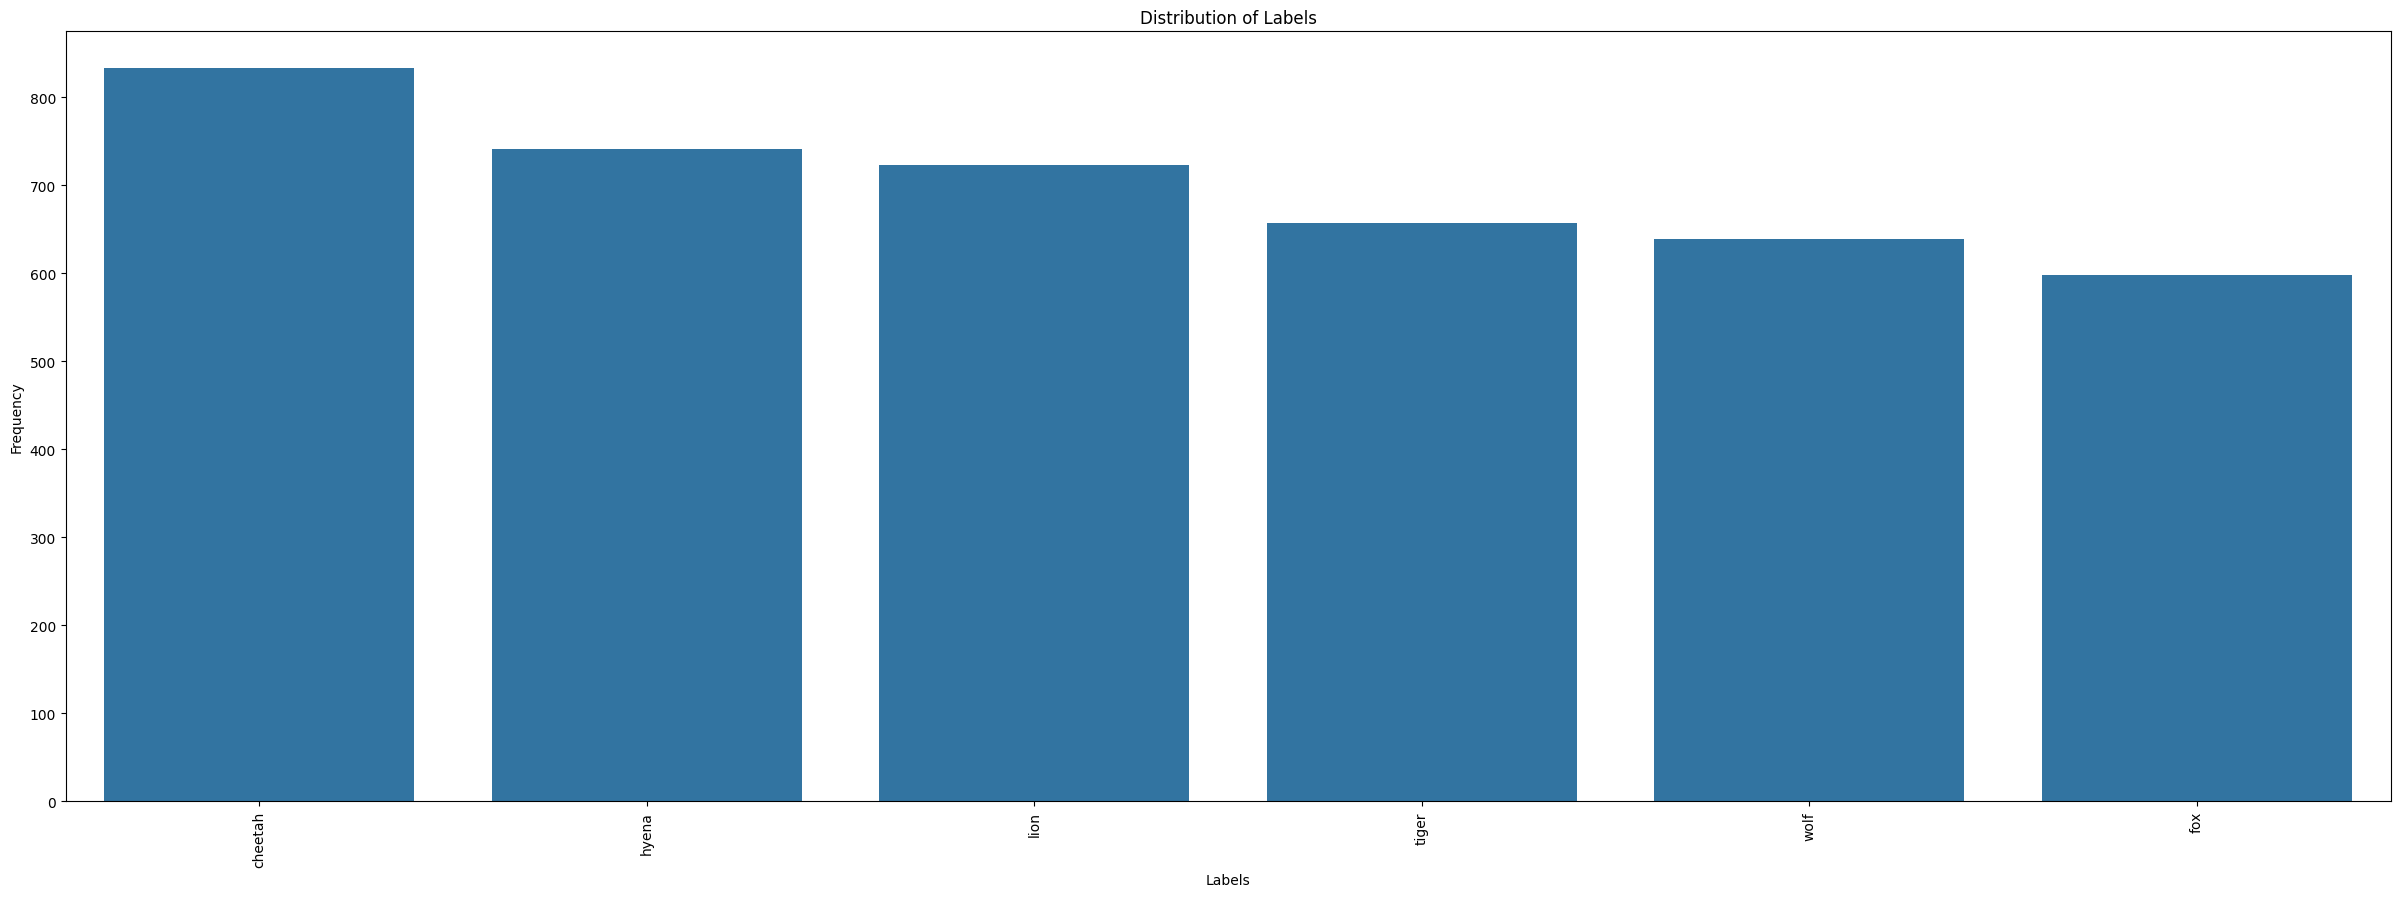

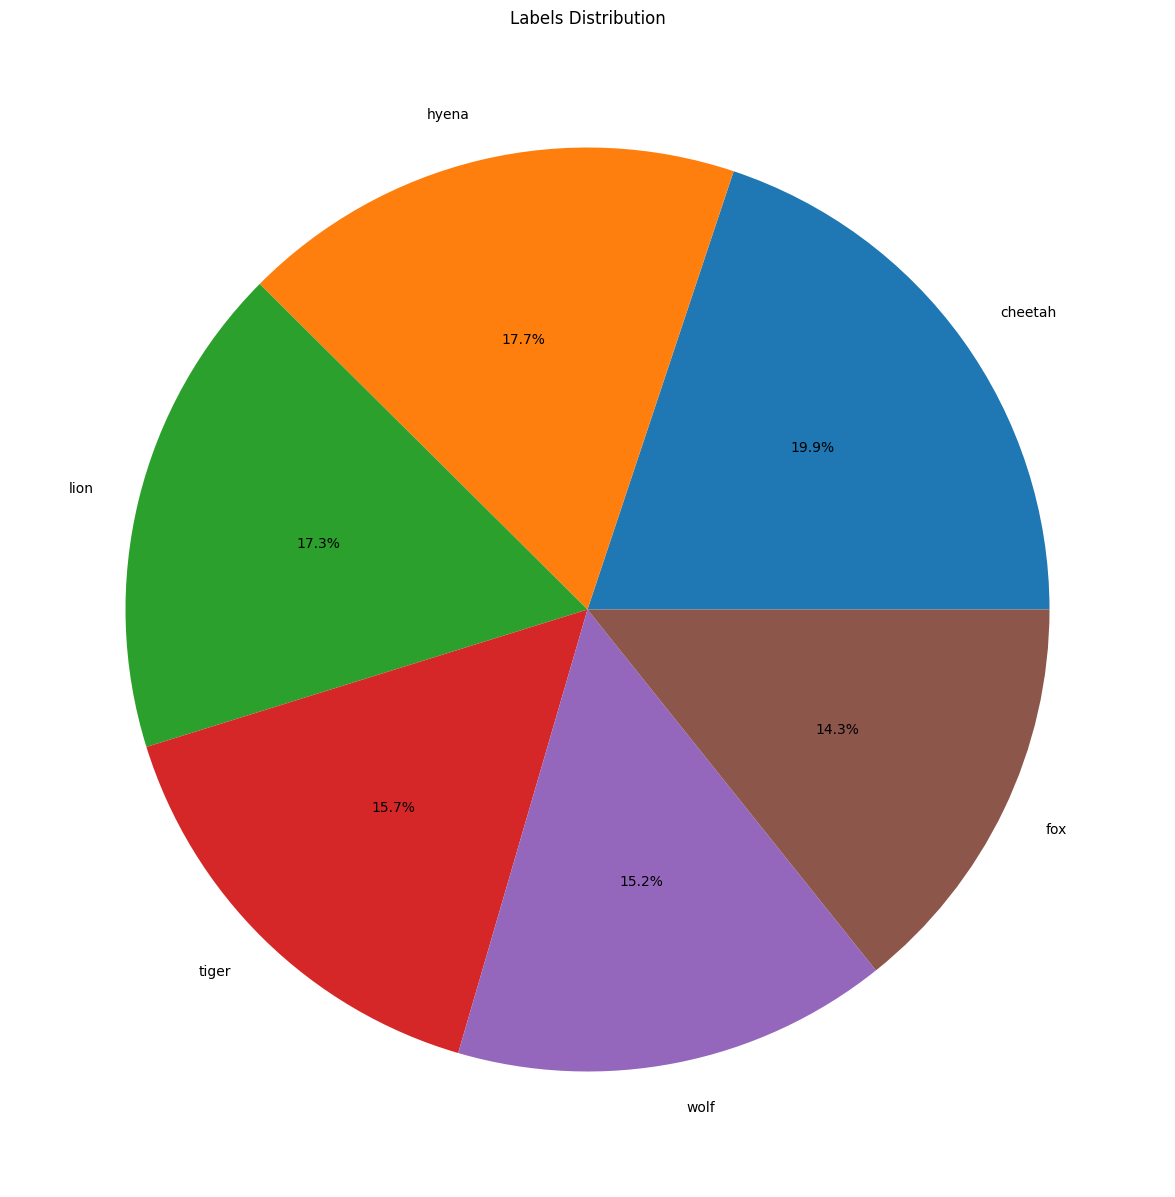

In [15]:
# Bar chart for label distribution
plt.figure(figsize=(30, 10))
sns.countplot(data=train_df, x='Labels', order=train_df['Labels'].value_counts().index)
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.show()

# Pie chart for label distribution
plt.figure(figsize=(15, 15))
train_df['Labels'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Labels Distribution')
plt.ylabel('')  # Hide the y-label
plt.show()

Number of unique image paths: 4191


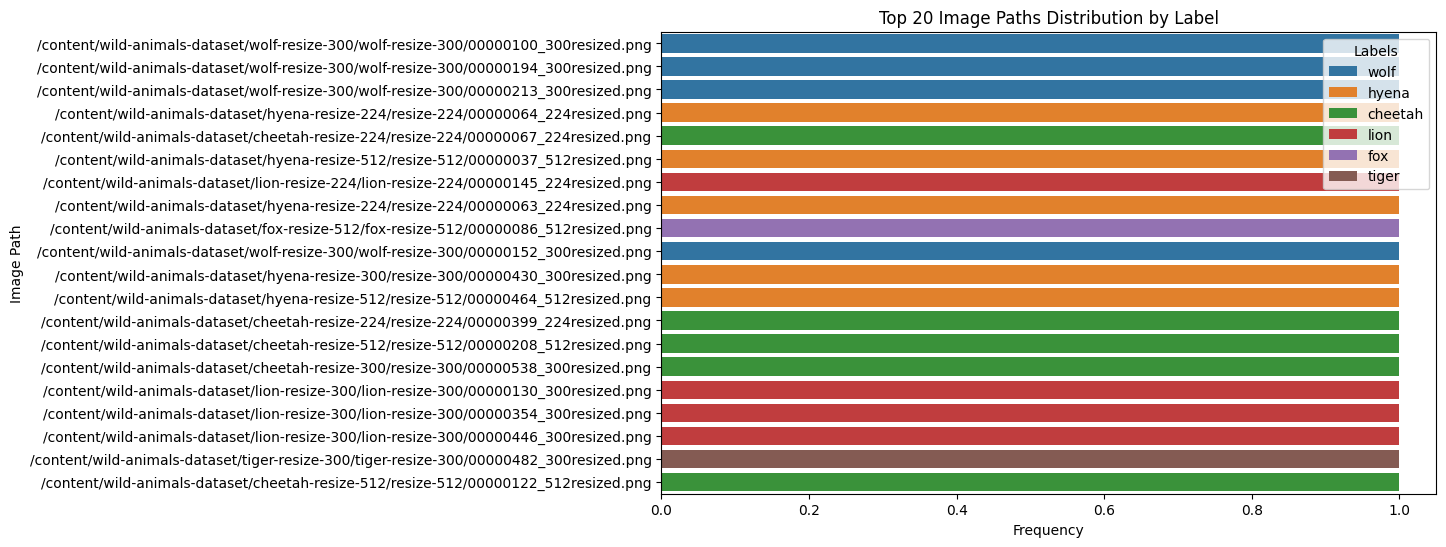

Column Image_Path has 4191 unique values.
Column Labels has 6 unique values.


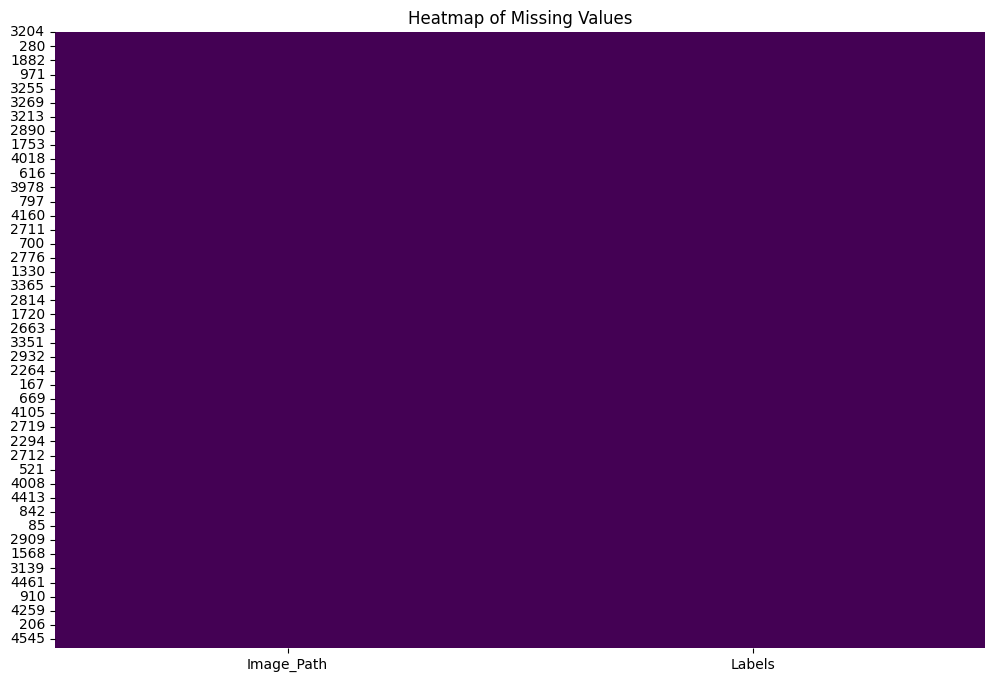

Labels
cheetah    833
hyena      741
lion       723
tiger      657
wolf       639
fox        598
Name: count, dtype: int64


In [16]:
# Count unique image paths
unique_paths = train_df['Image_Path'].nunique()
print(f"Number of unique image paths: {unique_paths}")

# Image paths distribution by label (top 20 paths for readability)
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, y='Image_Path', hue='Labels', order=train_df['Image_Path'].value_counts().index[:20])
plt.title('Top 20 Image Paths Distribution by Label')
plt.xlabel('Frequency')
plt.ylabel('Image Path')
plt.show()

# Unique values for each categorical column
for column in train_df.select_dtypes(include=['object']).columns:
    unique_values = train_df[column].nunique()
    print(f"Column {column} has {unique_values} unique values.")

# Missing values heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

# Label counts summary
label_counts = train_df['Labels'].value_counts()
print(label_counts)

In [17]:
# Data Cleaning
print(train_df.isnull().sum())
train_df.fillna(method='ffill', inplace=True)
print(train_df.duplicated().sum())
train_df.drop_duplicates(inplace=True)

Image_Path    0
Labels        0
dtype: int64
0


# Customizing model according to our usecase
This code snippet summarizes the process of creating a custom keras categorical classification model in Keras. It involves loading the pre-trained Xception , VGG16 and ResNet50  model, freezing its layers, adding custom layers for classification, compiling the model, shuffling the training data, and training the model. Finally, the trained model is saved as an HDF5 file .

In [18]:
from keras import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications import ResNet101V2
from keras.callbacks import EarlyStopping
from keras import optimizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os

def create_model(base_model, input_shape, num_classes):
    base_model.trainable = True
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [19]:
from keras.callbacks import EarlyStopping
from keras import optimizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def train_and_evaluate(model, train_data, val_data, model_name, epochs=10):
    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model with the specified number of epochs
    history = model.fit(train_data,
                        validation_data=val_data,
                        steps_per_epoch=len(train_data),
                        epochs=epochs,
                        callbacks=[early_stopping])

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(val_data)
    print(f'{model_name} Validation Accuracy: {val_accuracy:.4f}')

    # Plot training history
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Accuracy')
    plt.show()

    # Get the true labels and predictions
    val_steps = len(val_data)  # Number of validation steps
    Y_pred = model.predict(val_data, steps=val_steps)
    y_pred = np.argmax(Y_pred, axis=1)

    # Manually capture true labels from the generator
    y_true = []
    for i in range(val_steps):
        batch = val_data[i]
        y_true.extend(np.argmax(batch[1], axis=1))  # Assuming one-hot encoded labels

    y_true = np.array(y_true)

    # Map indices to class names
    class_indices = train_data.class_indices  # Use class indices from the training data generator
    class_labels = list(class_indices.keys())
    y_true_labels = [class_labels[i] for i in y_true]
    y_pred_labels = [class_labels[i] for i in y_pred]

    # Generate the confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=class_labels)
    plt.figure(figsize=(12, 8))  # Adjust the figure size to increase width
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return history

In [20]:
def model_training(base_models):
    save_dir = 'saved_models'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    histories = {}
    for base_model, input_shape, model_name in base_models:
        model = create_model(base_model, input_shape, num_classes)

        if model_name == 'ResNet50':
            for layer in model.layers[-30:]:
                layer.trainable = True
            epochs = 13
            optimizer = optimizers.Adam(learning_rate=0.0001)
        else:
            epochs = 13
            optimizer = optimizers.Adam()

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        print(f'Training {model_name}...')
        history = train_and_evaluate(model, train_generator, validation_generator, model_name, epochs=epochs)
        histories[model_name] = history

        model.save(os.path.join(save_dir, f'{model_name}_saved.h5'))
        print(f'Saved {model_name} model to {save_dir}/{model_name}_saved.h5')

# Loading the Base-Model
This code snippet defines Xception , ResNet50 and VGG16 base model in Keras. The model is configured with an input shape of (224, 224, 3) for VGG16 & ResNet50 and input shape of (299 , 299 , 3) for Xception to match the size and channels of the images in the dataset. It includes all layers of the MobileNetV2 model up to the final fully connected layers but excludes the last fully connected layer, which is often customized for specific tasks.

51877672/51877672 [==============================] - 4s 0us/step
Training DenseNet169...
Epoch 1/13
130/130 [==============================] - 212s 822ms/step - loss: 0.5232 - accuracy: 0.8300 - val_loss: 0.0098 - val_accuracy: 0.9978
Epoch 2/13
130/130 [==============================] - 93s 715ms/step - loss: 0.0834 - accuracy: 0.9800 - val_loss: 0.0973 - val_accuracy: 0.9821
Epoch 3/13
130/130 [==============================] - 104s 800ms/step - loss: 0.1551 - accuracy: 0.9738 - val_loss: 0.0178 - val_accuracy: 0.9978
Epoch 4/13
130/130 [==============================] - 94s 719ms/step - loss: 0.0524 - accuracy: 0.9887 - val_loss: 0.1259 - val_accuracy: 0.9799
Epoch 5/13
130/130 [==============================] - 96s 739ms/step - loss: 0.1769 - accuracy: 0.9677 - val_loss: 0.0228 - val_accuracy: 0.9955
Epoch 6/13
14/14 [==============================] - 4s 260ms/step - loss: 0.0099 - accuracy: 0.9978
DenseNet169 Validation Accuracy: 0.9978


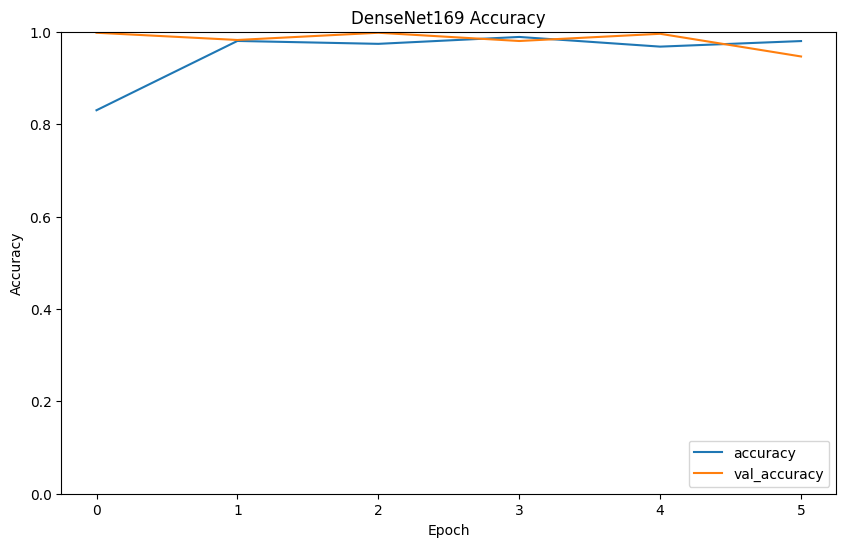

14/14 [==============================] - 5s 208ms/step


<Figure size 1200x800 with 0 Axes>

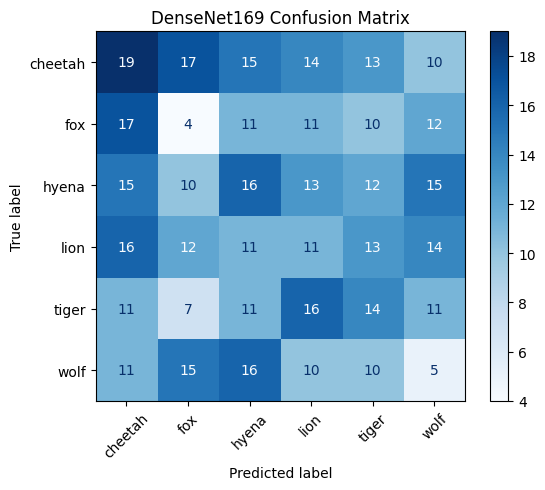

Saved DenseNet169 model to saved_models/DenseNet169_saved.h5


In [21]:
# List of base models with their respective input shapes
base_models1 = [
    (DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), (224, 224, 3), 'DenseNet169'),
]
model_training(base_models1)

87910968/87910968 [==============================] - 5s 0us/step
Training InceptionV3...
Epoch 1/13
130/130 [==============================] - 131s 694ms/step - loss: 0.5545 - accuracy: 0.8250 - val_loss: 0.0165 - val_accuracy: 0.9933
Epoch 2/13
130/130 [==============================] - 81s 621ms/step - loss: 0.1466 - accuracy: 0.9706 - val_loss: 0.0127 - val_accuracy: 0.9955
Epoch 3/13
130/130 [==============================] - 82s 632ms/step - loss: 0.1515 - accuracy: 0.9675 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 4/13
130/130 [==============================] - 88s 677ms/step - loss: 0.1605 - accuracy: 0.9711 - val_loss: 0.0302 - val_accuracy: 0.9955
Epoch 5/13
130/130 [==============================] - 82s 631ms/step - loss: 0.1305 - accuracy: 0.9738 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 6/13
130/130 [==============================] - 82s 632ms/step - loss: 0.0922 - accuracy: 0.9824 - val_loss: 0.0265 - val_accuracy: 0.9911
Epoch 7/13
130/130 [====================

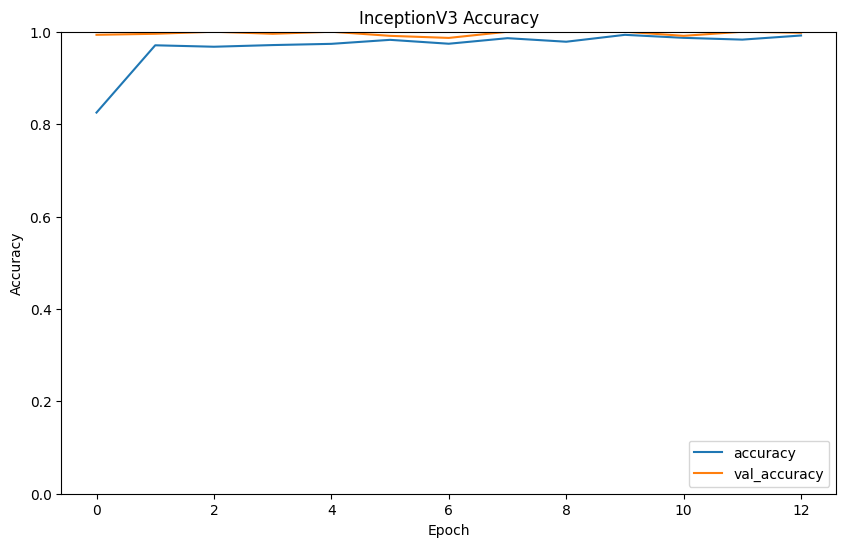

14/14 [==============================] - 4s 220ms/step


<Figure size 1200x800 with 0 Axes>

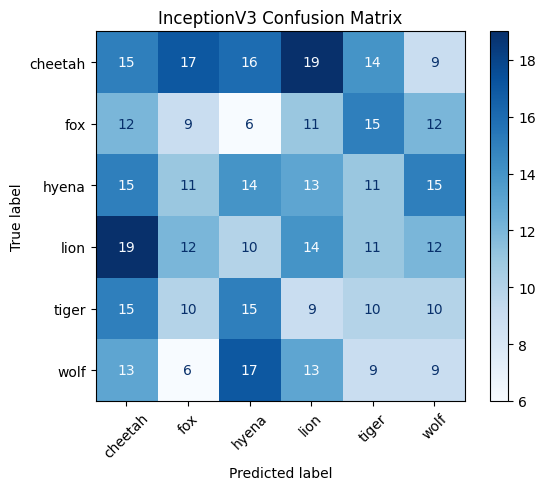

Saved InceptionV3 model to saved_models/InceptionV3_saved.h5


In [22]:
base_models2 = [
  (InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3)), (299, 299, 3), 'InceptionV3')
]
model_training (base_models2)

83683744/83683744 [==============================] - 5s 0us/step
Training Xception...
Epoch 1/13
130/130 [==============================] - 134s 782ms/step - loss: 0.5451 - accuracy: 0.8394 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 2/13
130/130 [==============================] - 94s 722ms/step - loss: 0.0526 - accuracy: 0.9863 - val_loss: 0.0048 - val_accuracy: 0.9978
Epoch 3/13
130/130 [==============================] - 94s 718ms/step - loss: 0.1502 - accuracy: 0.9769 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 4/13
130/130 [==============================] - 92s 710ms/step - loss: 0.0978 - accuracy: 0.9807 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 5/13
130/130 [==============================] - 94s 723ms/step - loss: 0.1615 - accuracy: 0.9747 - val_loss: 0.0168 - val_accuracy: 0.9978
Epoch 6/13
130/130 [==============================] - 101s 772ms/step - loss: 0.0302 - accuracy: 0.9937 - val_loss: 0.0147 - val_accuracy: 0.9955
Epoch 7/13
130/130 [======================

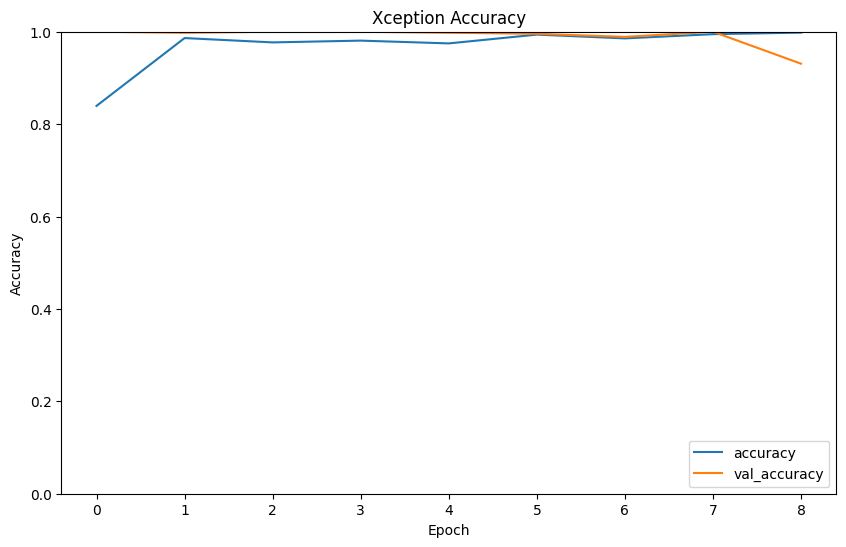

14/14 [==============================] - 4s 227ms/step


<Figure size 1200x800 with 0 Axes>

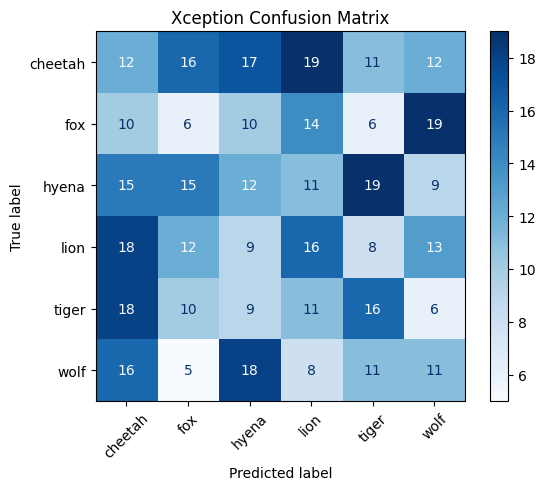

Saved Xception model to saved_models/Xception_saved.h5


In [23]:
base_models3 = [
  (Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3)), (299, 299, 3), 'Xception')
]
model_training (base_models3)

94668760/94668760 [==============================] - 6s 0us/step
Training ResNet50V2...
Epoch 1/13
130/130 [==============================] - 124s 711ms/step - loss: 0.6502 - accuracy: 0.7744 - val_loss: 0.0353 - val_accuracy: 0.9821
Epoch 2/13
130/130 [==============================] - 85s 654ms/step - loss: 0.1943 - accuracy: 0.9538 - val_loss: 0.0529 - val_accuracy: 0.9844
Epoch 3/13
130/130 [==============================] - 87s 667ms/step - loss: 0.1806 - accuracy: 0.9670 - val_loss: 0.0398 - val_accuracy: 0.9888
Epoch 4/13
130/130 [==============================] - 85s 654ms/step - loss: 0.2055 - accuracy: 0.9629 - val_loss: 0.1004 - val_accuracy: 0.9844
Epoch 5/13
130/130 [==============================] - 88s 673ms/step - loss: 0.1091 - accuracy: 0.9793 - val_loss: 0.0136 - val_accuracy: 0.9978
Epoch 6/13
130/130 [==============================] - 85s 655ms/step - loss: 0.0974 - accuracy: 0.9824 - val_loss: 0.4334 - val_accuracy: 0.9420
Epoch 7/13
130/130 [=====================

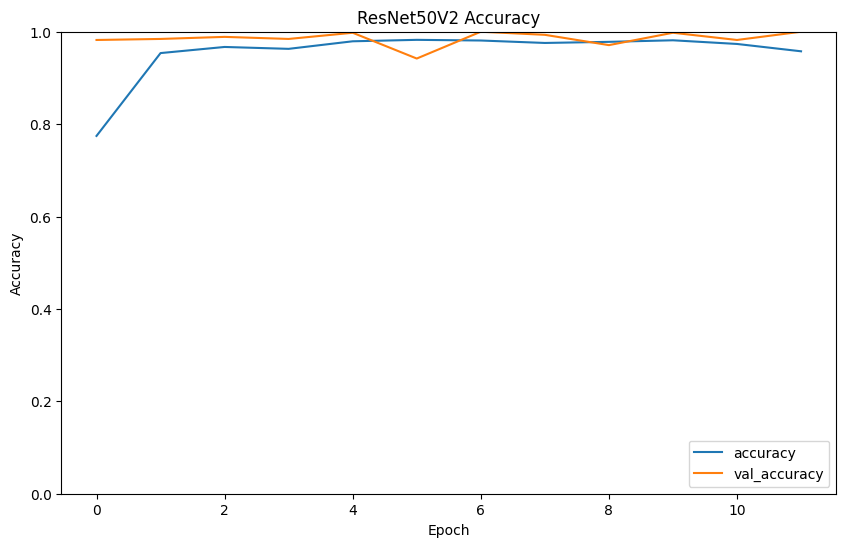

14/14 [==============================] - 4s 201ms/step


<Figure size 1200x800 with 0 Axes>

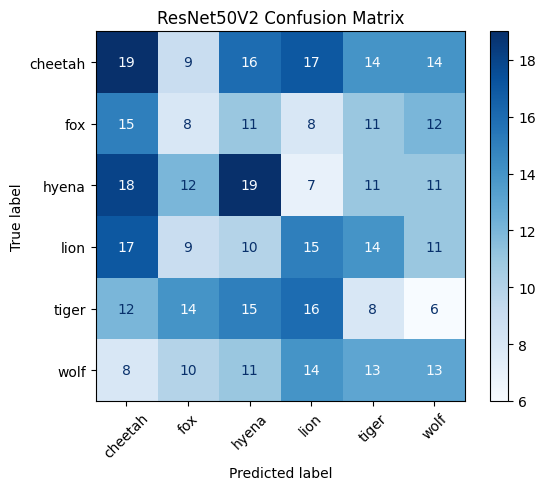

Saved ResNet50V2 model to saved_models/ResNet50V2_saved.h5


In [24]:
base_models4 = [
  (ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), (224, 224, 3), 'ResNet50V2')
]
model_training (base_models4)

29084464/29084464 [==============================] - 2s 0us/step
Training DenseNet121...
Epoch 1/13
130/130 [==============================] - 145s 707ms/step - loss: 0.7799 - accuracy: 0.7458 - val_loss: 0.0611 - val_accuracy: 0.9888
Epoch 2/13
130/130 [==============================] - 90s 688ms/step - loss: 0.1468 - accuracy: 0.9673 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 3/13
130/130 [==============================] - 88s 678ms/step - loss: 0.1701 - accuracy: 0.9692 - val_loss: 0.0089 - val_accuracy: 1.0000
Epoch 4/13
130/130 [==============================] - 91s 696ms/step - loss: 0.0942 - accuracy: 0.9822 - val_loss: 0.2558 - val_accuracy: 0.9665
Epoch 5/13
130/130 [==============================] - 87s 669ms/step - loss: 0.1240 - accuracy: 0.9776 - val_loss: 0.0120 - val_accuracy: 1.0000
Epoch 6/13
130/130 [==============================] - 89s 686ms/step - loss: 0.0804 - accuracy: 0.9831 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 7/13
130/130 [====================

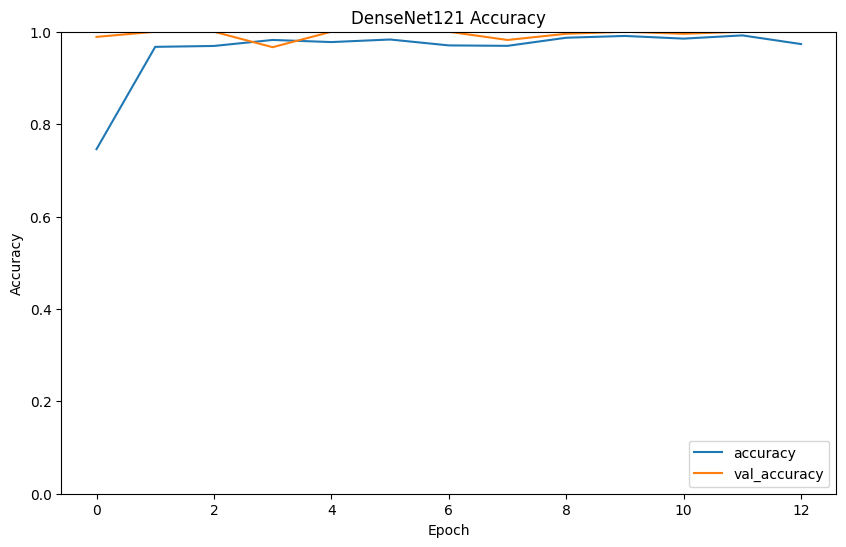

14/14 [==============================] - 5s 199ms/step


<Figure size 1200x800 with 0 Axes>

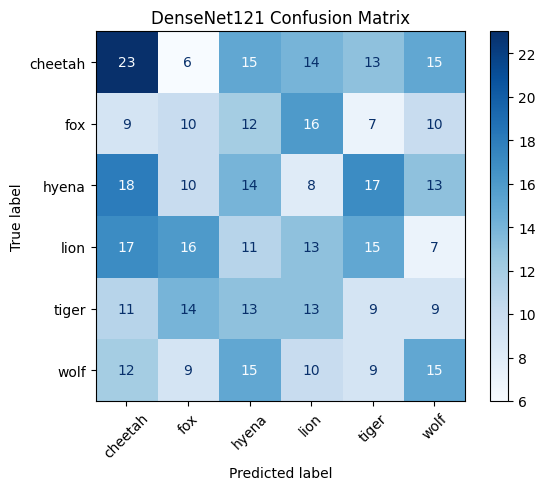

Saved DenseNet121 model to saved_models/DenseNet121_saved.h5


In [25]:
# List of base models with their respective input shapes
base_models5 = [
   (DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), (224, 224, 3), 'DenseNet121')
]
model_training (base_models5)

# Testing and labeling unseen data

In [31]:
import os
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.preprocessing import image
from tqdm.notebook import tqdm

# Load test dataset
test_df = pd.read_csv('/content/wild-animals-dataset/test_data.csv')

# Load class indices (assuming you have train_generator with class indices saved)
class_indices_inverse = {v: k for k, v in train_generator.class_indices.items()}

# Directory containing the saved models
model_dir = '/content/saved_models'

# Define batch size
batch_size = 32

# Function to process images in batches
def process_images_in_batches(image_paths, model, target_size, batch_size):
    num_images = len(image_paths)
    num_batches = (num_images + batch_size - 1) // batch_size  # Calculate number of batches

    all_predictions = []

    for batch_idx in tqdm(range(num_batches), desc="Processing batches"):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_images)
        batch_paths = image_paths[start_idx:end_idx]

        batch_images = []
        for img_path in batch_paths:
            img = image.load_img(img_path, target_size=target_size)
            img = image.img_to_array(img)
            img = img / 255.0
            batch_images.append(img)

        batch_images = np.array(batch_images)
        batch_predictions_probs = model.predict(batch_images, verbose=0)
        batch_predictions = np.argmax(batch_predictions_probs, axis=1)

        all_predictions.extend(batch_predictions)

    return all_predictions

# Iterate over each model file in the directory
for model_file in os.listdir(model_dir):
    if model_file.endswith('.h5'):
        # Load the model
        model_path = os.path.join(model_dir, model_file)
        model = load_model(model_path)

        # Determine target size based on model
        if "Xception_saved" in model_file or "InceptionV3_saved" in model_file:
            target_size = (299, 299)
        else:
            target_size = (224, 224)

        # Process images in batches and make predictions
        image_paths = test_df['Image_Path'].tolist()
        prediction = process_images_in_batches(image_paths, model, target_size, batch_size)

        # Map predictions to class labels
        prediction_labels = [class_indices_inverse[label] for label in prediction]

        # Create a DataFrame with predictions
        predicted_df = pd.DataFrame({
            'Image_Path': test_df['Image_Path'],
            'True_Labels': test_df['True_Labels'],
            'Predicted_Labels': prediction_labels,
        })

        # Calculate accuracy
        accuracy = np.mean(predicted_df['True_Labels'] == predicted_df['Predicted_Labels'])

        # Save predictions to CSV
        csv_path = f'/content/saved_models/predicted_{model_file.split(".")[0]}.csv'
        predicted_df.to_csv(csv_path, header=True, index=False)

        print(f"Predictions saved to {csv_path}")
        print(f"Test Accuracy: {accuracy:.2%}")

Processing batches:   0%|          | 0/17 [00:00<?, ?it/s]

Predictions saved to /content/saved_models/predicted_ResNet50V2_saved.csv
Test Accuracy: 99.81%


Processing batches:   0%|          | 0/17 [00:00<?, ?it/s]

Predictions saved to /content/saved_models/predicted_DenseNet121_saved.csv
Test Accuracy: 100.00%


Processing batches:   0%|          | 0/17 [00:00<?, ?it/s]

Predictions saved to /content/saved_models/predicted_InceptionV3_saved.csv
Test Accuracy: 99.81%


Processing batches:   0%|          | 0/17 [00:00<?, ?it/s]

Predictions saved to /content/saved_models/predicted_Xception_saved.csv
Test Accuracy: 100.00%


Processing batches:   0%|          | 0/17 [00:00<?, ?it/s]

Predictions saved to /content/saved_models/predicted_DenseNet169_saved.csv
Test Accuracy: 99.42%


# image label and prediction and visualization

Predictions using: predicted_DenseNet169_saved


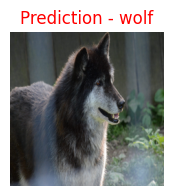

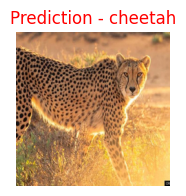

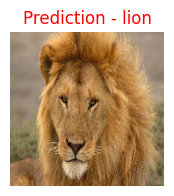

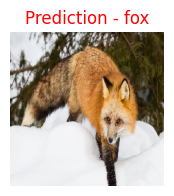

Predictions using: predicted_DenseNet121_saved


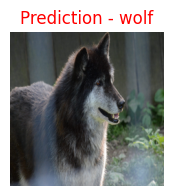

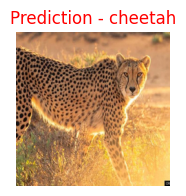

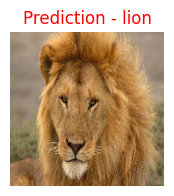

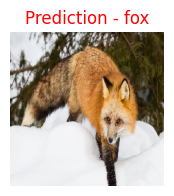

Predictions using: predicted_InceptionV3_saved


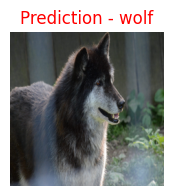

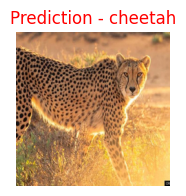

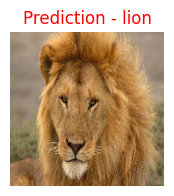

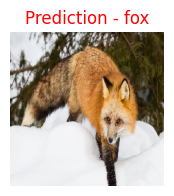

Predictions using: predicted_Xception_saved


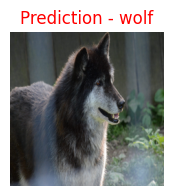

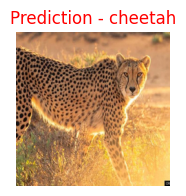

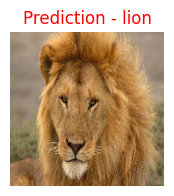

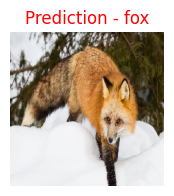

Predictions using: predicted_ResNet50V2_saved


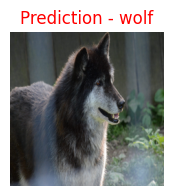

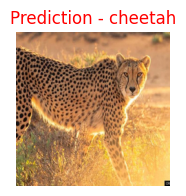

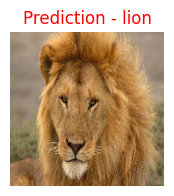

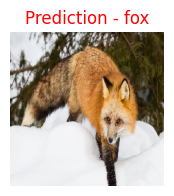

In [33]:
import csv
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt

# Example usage
filenames = [
    '/content/wild-animals-dataset/wolf-resize-224/wolf-resize-224/00000378_224resized.png',
    '/content/wild-animals-dataset/cheetah-resize-512/resize-512/00000010_512resized.png',
    '/content/wild-animals-dataset/lion-resize-512/lion-resize-512/00000013_512resized.png',
    '/content/wild-animals-dataset/fox-resize-512/fox-resize-512/00000179_512resized.png'
]

def load_predicted_labels(csv_file_path):
    predicted_labels = {}
    with open(csv_file_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            predicted_labels[row['Image_Path']] = row['Predicted_Labels']
    return predicted_labels

def visualize_predictions(filenames, predicted_labels):
    for filename in filenames:
        img = image.load_img(filename, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_processed = img_array / 255.0  # Normalize the image

        # Check if the filename is in predicted_labels
        if filename in predicted_labels:
            predicted_class_name = predicted_labels[filename]
        else:
            print(f"Filename not found: {filename}")
            predicted_class_name = "Unknown"  # Handle cases where filename not found

        plt.figure(figsize=(2, 2))
        plt.imshow(img_processed)  # Display the processed image
        plt.title(f"Prediction - {predicted_class_name}", size=12, color='red')
        plt.axis('off')  # Hide axes
        plt.show()

# Directory containing the predicted CSV files
csv_dir = '/content/saved_models'

# Iterate over each CSV file in the directory
for csv_file in os.listdir(csv_dir):
    if csv_file.startswith('predicted_') and csv_file.endswith('.csv'):
        # Determine the model name
        model_name = csv_file.split('.')[0]

        # Path to the CSV file containing predictions for the current model
        predicted_csv_file = os.path.join(csv_dir, csv_file)

        # Load predicted labels from the CSV file
        predicted_labels = load_predicted_labels(predicted_csv_file)

        # Predict and plot images using predicted labels
        print(f"Predictions using: {model_name}")
        visualize_predictions(filenames, predicted_labels)
